In [1]:
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input, decode_predictions
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from PIL import Image
import pickle

In [ ]:
from os import listdir
from pickle import dump
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from keras.models import Model
def extract_features(directory):
	model=VGG16()
	model.layers.pop()
	model=Model(inputs=model.inputs,outputs=model.layers[-1].output)
	print(model.summary())
	features = {}
	for name in listdir(directory):
		filename=directory + '/' + name
		image=load_img(filename, target_size=(224, 224))
		image=img_to_array(image)
		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
		image = preprocess_input(image)
		feature = model.predict(image, verbose=0)
		image_id = name.split('.')[0]
		features[image_id] = feature
		print('>%s' % name)
	return features

directory = 'Customize16kDataset'
features = extract_features(directory)
print('Extracted Features: %d' % len(features))
dump(features, open('features.pkl', 'wb'))



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [2]:
import pickle
with open('features.pkl', 'rb') as f:
    features = pickle.load(f)

In [3]:
with open('Captions.txt', 'r', encoding='utf-8') as f:
    next(f)
    captions_doc = f.read()

In [4]:
captions_doc

'1.jpg   দুই শিশু গ্রামে হাঁটছে।\n1.jpg   একটা নীল জামা পড়া শিশু।\n1.jpg   দুই শিশু খেলা করে।\n1.jpg   দুইটা শিশু দাঁড়িয়ে আছে।\n2.jpg   কিছু লোক নদী পার করছে।\n2.jpg   কিছু লোক বিল পার করছে।\n2.jpg   অনেকগুলো লোক নদী পার করছে।\n2.jpg   জমির ভিতর অনেকগুলো লোক।\n2.jpg   কিছু লোক নদী পার করছে।\n3.jpg   এক কৃষক ক্ষেতে কাজ করছে।\n3.jpg   এক কৃষক ধান ক্ষেতে কাজ করছে।\n3.jpg   রোদ এর নিচে একটা লোক দাঁড়িয়ে আছে।\n3.jpg   এক কৃষক ধান দেখছে।\n3.jpg   শার্ট পড়া একটা লোক।\n4.jpg   কিছু শিশু তাদের স্কুল থেকে বাড়িতে যায়।\n4.jpg   কিছু শিশু ও একটি ভবন।\n4.jpg   ভবনে কিছু শিশু খেলা করে।\n4.jpg   সবুজ ধান ক্ষেত।\n4.jpg   স্কুলের জামা পড়া কিছু শিশু।\n5.jpg   পাঁচটি নারী এক জায়গায় চলছে।\n5.jpg   পাঁচটি শিশু এক জায়গায় চলছে।\n5.jpg   পাঁচটি মেয়ে খেলছে।\n5.jpg   হাসিমুখে পাঁচটি মেয়ে।\n5.jpg   পাঁচটি মেয়ে খেলতেছে।\n6.jpg   কিছু লোক পাহাড়ে বসে আছে।\n6.jpg   কিছু লোক বসে আছে।\n6.jpg   রোদ এর নিছে কিছু লোক বসে আছে।\n6.jpg   পাহারের উপর কিছু লোক বসে আছে।\n6.jpg   হাসিমুখে কিছু লোক বসে আছে।\n7.jpg   নদীর পা

In [5]:
from tqdm import tqdm
mapping = {}

for line in tqdm(captions_doc.split('\n')):
    tokens = line.split(' ')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    image_id = image_id.split('.')[0]
    caption = " ".join(caption)
    if image_id not in mapping:
        mapping[image_id] = []
    
    mapping[image_id].append(caption)

100%|████████████████████████████████████████████████████████████████████████| 79562/79562 [00:00<00:00, 284527.25it/s]


In [6]:
len(mapping)

16091

In [8]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
           
            caption = captions[i]
            caption = caption.lower() 
            caption = caption.replace('।', '')
            caption = caption.replace('\s+', ' ')
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [9]:
clean(mapping)

mapping['1']

['startseq দুই শিশু গ্রামে হাঁটছে endseq',
 'startseq একটা নীল জামা পড়া শিশু endseq',
 'startseq দুই শিশু খেলা করে endseq',
 'startseq দুইটা শিশু দাঁড়িয়ে আছে endseq']

In [10]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [11]:
len(all_captions)

79559

In [12]:
all_captions[:10]

['startseq দুই শিশু গ্রামে হাঁটছে endseq',
 'startseq একটা নীল জামা পড়া শিশু endseq',
 'startseq দুই শিশু খেলা করে endseq',
 'startseq দুইটা শিশু দাঁড়িয়ে আছে endseq',
 'startseq কিছু লোক নদী পার করছে endseq',
 'startseq কিছু লোক বিল পার করছে endseq',
 'startseq অনেকগুলো লোক নদী পার করছে endseq',
 'startseq জমির ভিতর অনেকগুলো লোক endseq',
 'startseq কিছু লোক নদী পার করছে endseq',
 'startseq এক কৃষক ক্ষেতে কাজ করছে endseq']

In [13]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [14]:
vocab_size

20608

In [15]:
max_length = max(len(caption.split()) for caption in all_captions)
max_length

41

In [16]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.80)
train = image_ids[:split]
test = image_ids[split:]

In [17]:
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            for caption in captions:
                seq = tokenizer.texts_to_sequences([caption])[0]
                for i in range(1, len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0

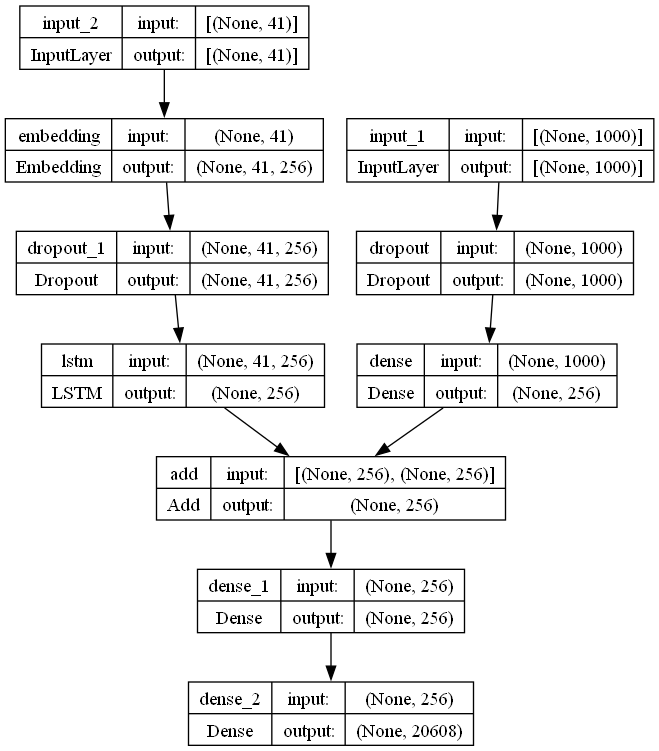

In [18]:
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from keras.models import Model
from keras.utils import plot_model

inputs1 = Input(shape=(1000,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

plot_model(model, show_shapes=True)

In [23]:
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

402/402 [==============================] - 1030s 3s/step - loss: 2.6948


In [24]:
model.save('best_model.h5')

C:\Users\user\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [19]:
from tensorflow.keras.models import load_model
model = load_model('best_model.h5')

In [20]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [21]:
def predict_caption(model, image, tokenizer, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)
        yhat = model.predict([image, sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = idx_to_word(yhat, tokenizer)
        if word is None:
            break
        
        in_text += " " + word
        if word == 'endseq':
            break
      
    return in_text

---------------------------Actual captions ----------------
startseq বাদামী কুকুর একটি লাল কুকুর সৈকতে পানির পাশে দৌড়াচ্ছে endseq
startseq ব্রাউন কুকুর সমুদ্রের পাশে সৈকতে দৌড়াচ্ছে endseq
startseq বালির সৈকতে দুটি বাদামী কুকুর মজার ছলে খেলছে endseq
startseq বাদামি কুকুর জলের পাশে বালুতে খেলছে endseq
startseq কুকুর একটি সৈকতে ছুটছে endseq
---------------------------Predicted Images-----------------
startseq কুকুর একটি বাদামী কুকুরের পাশে খেলছে endseq


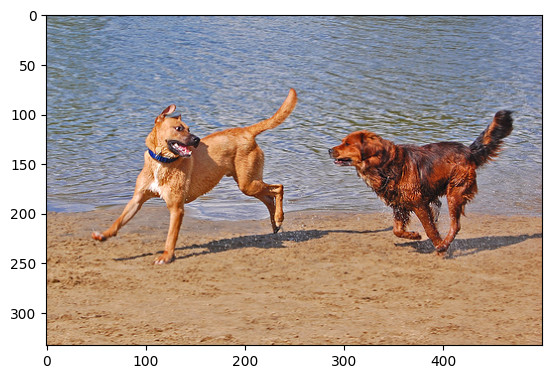

In [31]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def generate_caption(image_name):
    image_id = image_name.split('.')[0]
    img_path = os.path.join('Customize16kDataset', image_name)
    image = Image.open(img_path)

    captions = mapping[image_id]

    print('---------------------------Actual captions ----------------')
    for caption in captions:
        print(caption)

    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)

    print('---------------------------Predicted Images-----------------')
    print(y_pred)

    plt.imshow(image)
    plt.show()  

generate_caption("2658009523_b49d611db8.jpg")

---------------------------Actual captions ----------------
startseq এক কৃষক ক্ষেতে কাজ করছে endseq
startseq এক কৃষক ধান ক্ষেতে কাজ করছে endseq
startseq রোদ এর নিচে একটা লোক দাঁড়িয়ে আছে endseq
startseq এক কৃষক ধান দেখছে endseq
startseq শার্ট পড়া একটা লোক endseq
---------------------------Predicted Images-----------------
startseq লোক একটি বড় গাছের পাশে দাড়িয়ে আছে endseq


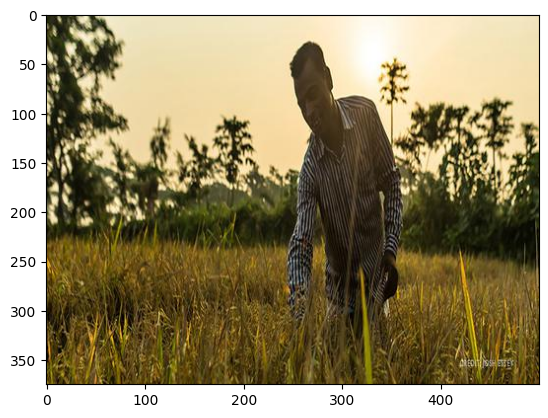

In [34]:
generate_caption("3.jpg")

---------------------------Actual captions ----------------
startseq একজন নারী একটি শিশু কোলে নিয়ে আছে endseq
startseq একজন মহিলা একজন বাচ্চাকে কোলে নিয়ে হাসছেন endseq
startseq একজন মা তার সন্তানকে আদর করছেন endseq
startseq মহিলাটি তার সন্তানকে কোলে নিয়ে জমির মাঝে দাড়িয়ে আছেন endseq
startseq একজন নারী হাসিমুখে বাচ্চাটির পানে তাকিয়ে আছেন endseq
---------------------------Predicted Images-----------------
startseq লোক একটি শিশুকে কোলে নিয়ে আছে endseq


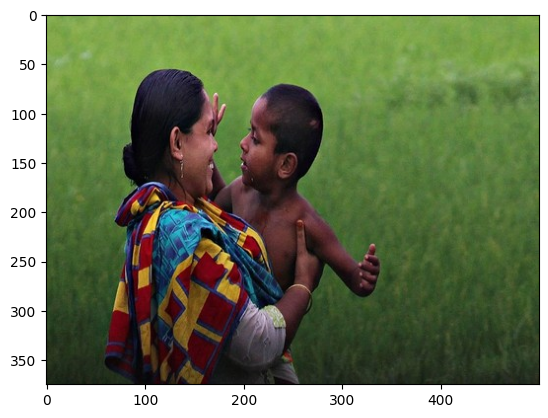

In [48]:
generate_caption("4987.jpg")

---------------------------Actual captions ----------------
startseq লাল-সাদা জামা পরা একটা বাচ্চা মেয়ে হাঁসি দিয়ে তাকিয়ে আছে endseq
startseq একটি শিশু হাসছে endseq
startseq একটি শিশু আছে endseq
startseq একটি শিশু হাসি মুখে তাকিয়ে আছে endseq
startseq একটি শিশু ব্রেঞ্চের নিচে দাঁড়িয়ে আছে endseq
---------------------------Predicted Images-----------------
startseq বাচ্চা মেয়ে একটি জানাল থেকে দেখছে endseq


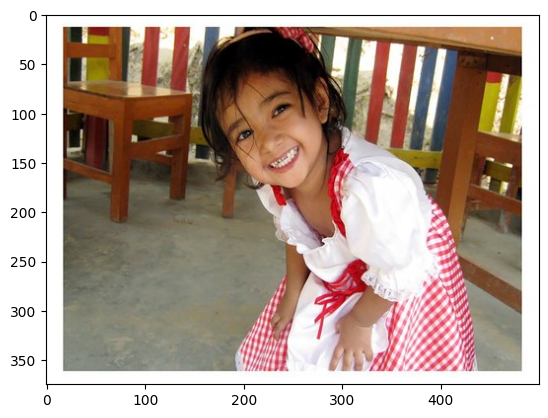

In [52]:
generate_caption("7999.jpg")

---------------------------Actual captions ----------------
startseq কিছু শিশু বালির মধ্যে খেলা করছে endseq
startseq কিছু শিশু খালি জায়গায় ছুটাছুটি করছে endseq
startseq কিছু শিশু খালি জায়গায় খেলা করছে endseq
startseq কিছু শিশু এলমেলভাবে দৌড়াচ্ছে endseq
startseq কিছু শিশু বালির মধ্যে এলমেলভাবে দৌড়াচ্ছে endseq
---------------------------Predicted Images-----------------
startseq লোক একটি বিশাল রাফটে খেলছে endseq


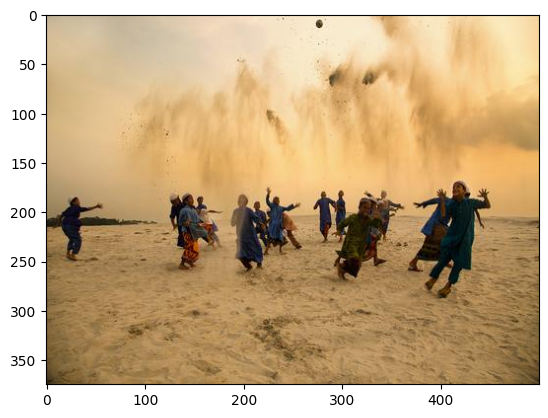

In [36]:
generate_caption("10.jpg")

---------------------------Actual captions ----------------
startseq লোক সমুদ্রে স্কুবা ডাইভিং করছে endseq
startseq নিচে স্কুবা ডাইভিংয়ে থাকা দু'জন ব্যক্তি endseq
startseq লোক অসংখ্য বুদবুদ তৈরি করে নীল পানিতে স্কুবা ডাইভিংকরছে endseq
startseq লোক সমুদ্রের নীল জলের গভীরে স্কুবা ডাইভিং করছে endseq
startseq ডুবুরী পানির নিচে endseq
---------------------------Predicted Images-----------------
startseq লোক একটি প্রবল স্রোতের মধ্যে সার্ফ করছে endseq


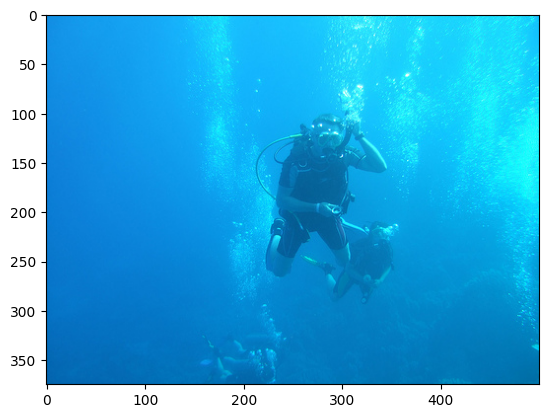

In [60]:
generate_caption("2711075591_f3ee53cfaa.jpg")

---------------------------Actual captions ----------------
startseq শার্টের একটি লোক একটি শিলার উপরে উঠেছিল endseq
startseq মানুষ পাথরে চড়ছে অনেক উপরে endseq
startseq শার্টের একজন ব্যক্তি সহায়তার হাতলগুলিতে ঢাকা একটি শিলা মুখ উপরে উঠেছেন endseq
startseq শার্টে একটি রক আরোহী endseq
startseq রক আরোহী একটি শৈল আরোহণ প্রাচীর এর উপর অনুশীলন করে endseq
---------------------------Predicted Images-----------------
startseq লোক পর্রবতের পাশে একটি পাথরের উপর বসে আছে endseq


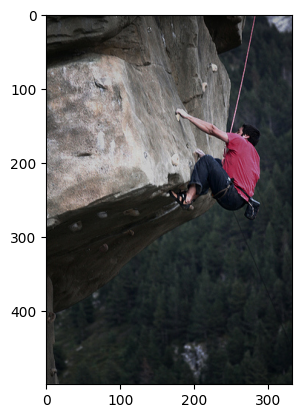

In [59]:
generate_caption("997722733_0cb5439472.jpg")

---------------------------Actual captions ----------------
startseq কালো তামাটে ডোবারম্যান কুকুর পানিতে দৌড়াচ্ছে endseq
startseq কুকুর হ্রদে জলের উপর দিয়ে ঝাঁপিয়ে পড়ে একটি কুকুর হ্রদে জলের উপর দিয়ে ঝাঁপিয়ে পড়ে endseq
startseq কালো কুকুর পানিতে দৌড়াচ্ছে endseq
startseq জলের মধ্য দিয়ে লাফিয়ে যাচ্ছে endseq
startseq পিন্সারটি পানির মধ্য দিয়ে লাফাচ্ছে endseq
---------------------------Predicted Images-----------------
startseq কুকুর একটি লাল বাহক টেনে নিয়ে যাচ্ছে endseq


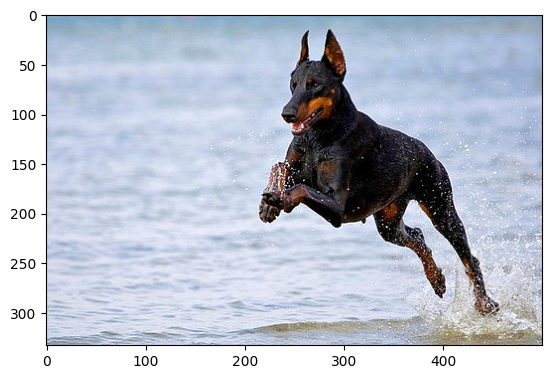

In [44]:
generate_caption("2637959357_dd64a03efa.jpg")

In [45]:
from nltk.translate.bleu_score import corpus_bleu
actual, predicted = list(), list()

for key in tqdm(test):
    captions = mapping[key]
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    actual.append(actual_captions)
    predicted.append(y_pred)
    
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

100%|██████████████████████████████████████████████████████████████████████████████| 3219/3219 [30:59<00:00,  1.73it/s]


BLEU-1: 0.498561
BLEU-2: 0.258587


In [46]:
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-3: 0.124404
BLEU-4: 0.050495
